In [116]:
import sys; sys.path.append('..')
from typing import List, Tuple, Dict

import torch
import numpy as np

In [5]:
import json

with open('../data/densepose/densepose_coco_2014_train.json', 'r') as f:
    train = json.load(f)

In [362]:
train['images'][0]

{'license': 2,
 'file_name': 'COCO_train2014_000000262145.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000262145.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-20 02:07:55',
 'flickr_url': 'http://farm8.staticflickr.com/7187/6967031859_5f08387bde_z.jpg',
 'id': 262145}

In [363]:
tiny_annos = train['annotations'][:100]
tiny_annos_imgs_idx = set([a['image_id'] for a in tiny_annos])
tiny_annos_imgs = [img for img in train['images'] if img['id'] in tiny_annos_imgs_idx]

tiny_coco = {
    'images': tiny_annos_imgs,
    'annotations': tiny_annos,
    'categories': train['categories']
}

with open('../data/densepose/densepose_coco_2014_tiny.json', 'w') as f:
    json.dump(tiny_coco, f)

In [39]:
from skimage.io import imread
import cv2

ann = train['annotations'][0]
img_path = f"/home/skorokhodov/densepose/coco/coco_train2014/COCO_train2014_{ann['image_id']:012d}.jpg"
img = imread(img_path)
bbox = Bbox.from_coco_ann(ann)
proposal = Bbox(380, 70, 140, 250)
red, green, blue = (255, 0, 0), (0, 255, 0), (0, 0, 255)

In [87]:
# cv2.remap(np.arange(16).reshape(4,4), [0, 1], [0.5, 1.5], cv2.INTER_NEAREST)

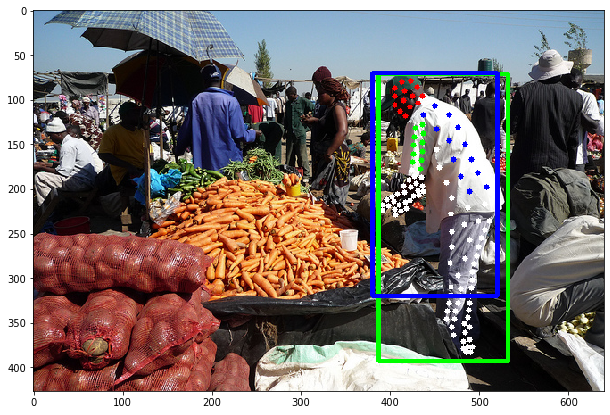

In [48]:
import matplotlib.pyplot as plt

def get_point_coords(ann, point_i):
    point = [ann['dp_x'][point_i], ann['dp_y'][point_i]]
    point[0] = ann['bbox'][0] + (point[0] / 256) * ann['bbox'][2]
    point[1] = ann['bbox'][1] + (point[1] / 256) * ann['bbox'][3]
    point = [int(p) for p in point]
    
    return point

for i in range(len(ann['dp_I'])):
    point = get_point_coords(ann, i)
    label = ann['dp_I'][i]
    if label == 24:
        color = red
    elif label == 1:
        color = blue
    elif label == 17:
        color = green
    else:
        color = (255, 255, 255)
    cv2.rectangle(img, tuple(point), tuple(point), color, 5)

cv2.rectangle(img, bbox.discretize().corners()[:2], bbox.discretize().corners()[2:], green, 3)
cv2.rectangle(img, proposal.discretize().corners()[:2], proposal.discretize().corners()[2:], blue, 3)
plt.figure(figsize=(15, 7))
plt.imshow(img)

In [227]:
from pycocotools import mask as mask_utils

masks = np.array([mask_utils.decode(m) if isinstance(m, dict) else np.zeros((256, 256)) for m in coco_ann['dp_masks']])

In [231]:
masks.sum(axis=0)

{0.0, 1.0}

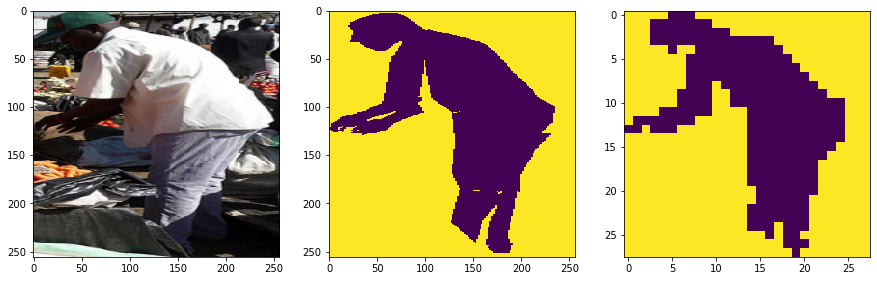

In [352]:
from skimage.transform import resize

bb = bbox.discretize()
bg_mask = np.invert(masks.sum(axis=0).astype(bool))

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(resize(img[bb.y:bb.y + bb.height, bb.x:bb.x + bb.width], (256, 256)))

plt.subplot(132)
plt.imshow(bg_mask)

plt.subplot(133)
# plt.imshow(resize(bg_mask.astype(np.float), (28, 28)) > 0.5)
plt.imshow(src.utils.dp_targets.downsample_mask(bg_mask, 28))

In [103]:
result = create_target_for_dp(ann, proposal, 50)

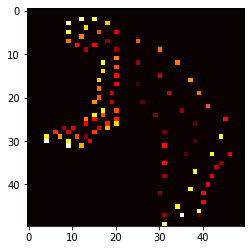

In [113]:
mask = np.zeros((50, 50))
mask[result['dp_y'], result['dp_x']] = result['dp_V']
plt.imshow(mask, cmap='hot')

In [349]:
import src.utils.dp_targets
import src.structures.bbox
reload(src.utils.dp_targets)
reload(src.structures.bbox)

<module 'src.structures.bbox' from '../src/structures/bbox.py'>

In [350]:
import src.utils.dp_targets
reload(src.utils.dp_targets)

M = 56
dp_targets = src.utils.dp_targets.create_target_for_dp(coco_ann, proposal, M)
cls_logits = torch.randn(M, M, 25)

src.utils.dp_targets.compute_dp_cls_loss(cls_logits, dp_targets)

(tensor(3.7303), tensor(3.7587))